<p style="border: 1px solid #e7692c; border-left: 15px solid #e7692c; padding: 10px; text-align:justify;">
    <strong style="color: #e7692c">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/Chapter03/ch3_nb3_experiment_with_optimizers.ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 3: Modern Neural Networks</strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">Notebook 3:</small><br/>Experimenting with Advanced Optimizers</h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    Several modern algorithms derived from the <em>stochastic gradient descent (SGD)</em> are presented in Chapter 3 <strong>improving the optimization process</strong>. This notebook will showcase their usage and effects on the training of our CNN for digit classification.
</p>
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [22]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

## Preparing the Data

We prepare the [MNIST](http://yann.lecun.com/exdb/mnist) dataset[$^1$](#ref) (Yann LeCun and Corinna Cortes hold all copyrights for this dataset), as done in the previous notebooks:

In [23]:
num_classes = 10
img_rows, img_cols, img_ch = 28, 28, 1
input_shape = (img_rows, img_cols, img_ch)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)

print('Training data: {}'.format(x_train.shape))
print('Testing data: {}'.format(x_test.shape))

Training data: (60000, 28, 28, 1)
Testing data: (10000, 28, 28, 1)


## Preparing the Model

We also reuse the _LeNet-5_ model[$^2$](#ref) we previously implemented. However, to make the code more concise, we build this simple model using `tf.keras.Sequential`, a class inheriting from `tf.keras.Model` to create sequential architectures. Also we wrap the network's instantiation into a function, so that we can spawn multiple ones:

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [25]:
def lenet(name='lenet'):
    model = Sequential(name=name)
    # 1st block:
    model.add(Conv2D(6, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 2nd block:
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Dense layers:
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

## Training with Various Optimizers


In [26]:
from tensorflow.keras import optimizers

# Setting some variables to format the logs:
log_begin_red, log_begin_blue, log_begin_green = '\033[91m', '\n\033[94m', '\033[92m'
log_begin_bold, log_begin_underline = '\033[1m', '\033[4m'
log_end_format = '\033[0m'

To showcase the effect that modern optimizers (available in TensorFlow and Keras) have on trainings, we will create several similar LeNet instance, and train each with a different optimizer.

First, we instantiate the various optimizers we want to compare[$^{3,4,5,6,7,8}$](#ref):

In [27]:
optimizers_examples = {
    'sgd': optimizers.SGD(),
    'momentum': optimizers.SGD(momentum=0.9),
    'nag': optimizers.SGD(momentum=0.9, nesterov=True),
    'adagrad': optimizers.Adagrad(),
    'adadelta': optimizers.Adadelta(),
    'rmsprop': optimizers.RMSprop(),
    'adam': optimizers.Adam()
}

For each optimizer we are considering, we will instantiate a new LeNet model and train it with. We will save their training `history` (containing the losses and metrics history over training), for comparison *(this process takes time, especially on CPU!)*:

In [28]:
history_per_optimizer = dict()

print("Experiment: {0}start{1} (training logs = off)".format(log_begin_red, log_end_format))
for optimizer_name in optimizers_examples:
    # Resetting the seeds (for random number generation), to reduce the impact of randomness on the comparison:
    tf.random.set_seed(42)
    np.random.seed(42)
    # Creating the model:
    model = lenet("lenet_{}".format(optimizer_name))
    optimizer = optimizers_examples[optimizer_name]
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # Launching the training (we set `verbose=0`, so the training won't generate any logs):
    print("\t> Training with {0}: {1}start{2}".format(
        optimizer_name, log_begin_red, log_end_format))
    history = model.fit(x_train, y_train,
                        batch_size=32, epochs=20, validation_data=(x_test, y_test),
                        verbose=0)
    history_per_optimizer[optimizer_name] = history
    print('\t> Training with {0}: {1}done{2}.'.format(
        optimizer_name, log_begin_green, log_end_format))
print("Experiment: {0}done{1}".format(log_begin_green, log_end_format))

Experiment: start (training logs = off)
	> Training with sgd: start
	> Training with sgd: done.
	> Training with momentum: start
	> Training with momentum: done.
	> Training with nag: start
	> Training with nag: done.
	> Training with adagrad: start
	> Training with adagrad: done.
	> Training with adadelta: start
	> Training with adadelta: done.
	> Training with rmsprop: start
	> Training with rmsprop: done.
	> Training with adam: start
	> Training with adam: done.
Experiment: done


We finally plot the training and validation losses + accuracies, for comparison:

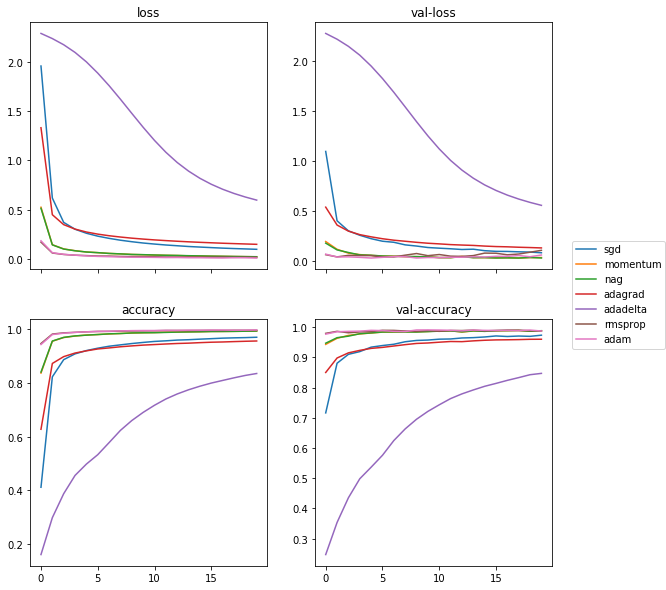

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("accuracy")
ax[1, 1].set_title("val-accuracy")

lines, labels = [], []
for optimizer_name in history_per_optimizer:
    history = history_per_optimizer[optimizer_name]
    ax[0, 0].plot(history.history['loss'])
    ax[0, 1].plot(history.history['val_loss'])
    ax[1, 0].plot(history.history['accuracy'])
    line = ax[1, 1].plot(history.history['val_accuracy'])
    lines.append(line[0])
    labels.append(optimizer_name)

fig.legend(lines,labels, loc='center right', borderaxespad=0.1)
plt.subplots_adjust(right=0.85)

## Conclusion

Though the end accuracy on the validation set does not differ by much from one instance to another (though `adadelta` is quite below here), we can clearly observe how models trained with more advanced optimizers converge faster. In many scenearios, any small gain in accuracy or in training time can be invaluable.

In the next notebook, we will pursue exploring modern training techniques, experimenting this time with _regularization_ methods.

<a id="ref"></a>
#### References

1. LeCun, Y., Cortes, C., Burges, C., 2010. MNIST handwritten digit database. AT&T Labs [Online]. Available: http://yann.lecun.com/exdb/mnist 2, 18.
2. LeCun, Yann. "*LeNet-5, convolutional neural networks.*" [http://yann.lecun.com/exdb/lenet](http://yann.lecun.com/exdb/lenet) (2015): 20.
3. Polyak, B.T., 1964. Some methods of speeding up the convergence of iteration methods. USSR Computational Mathematics and Mathematical Physics 4, 117.
4. Nesterov, Y., 1998. Introductory lectures on convex programming volume i: Basic course. Lecture notes.
5. Duchi, J., Hazan, E., Singer, Y., 2011. Adaptive subgradient methods for online learning and stochastic optimization. Journal of Machine Learning Research 12, 21212159.
6. Zeiler, M.D., 2012. ADADELTA: an adaptive learning rate method. arXiv preprint arXiv:1212.5701.
7. Tieleman, T., Hinton, G., 2012. Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude. COURSERA: Neural networks for machine learning 4, 2631.
8. Kingma, D.P., Ba, J., 2014. Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.